In [2]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')

Predicted: [('n02007558', 'flamingo', 0.9999957), ('n02006656', 'spoonbill', 1.8544538e-06), ('n02009912', 'American_egret', 8.507151e-07)]


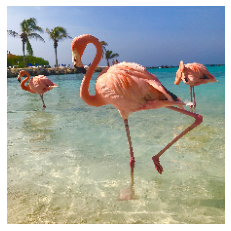

In [4]:
img_path = 'flamingo.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

In [5]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
# plot_img(x)

In [6]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)

In [ ]:
# Set variables
epochs = 400
epsilon = 0.01
prev_probs = []
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

for i in range(epochs): 
    # One hot encode the initial class
    target = K.one_hot(initial_class, 1000)
    print('target:',target.shape)
    print('model:',model.output)
    target = tf.expand_dims(target,axis = 1)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = K.categorical_crossentropy(target, tf.transpose(model.output))
    print('loss',loss)
    grads = K.gradients(loss, model.input)
    print('grads',grads)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    plot_img(x_adv)
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][initial_class])

    if i%20==0:
        print(i, preds[0][initial_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
plot_img(x_adv-x)

target: (1000,)
model: KerasTensor(type_spec=TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None), name='predictions/Softmax:0', description="created by layer 'predictions'")


In [23]:
print(model.output[])

KerasTensor(type_spec=TensorSpec(shape=(1000,), dtype=tf.float32, name=None), name='tf.__operators__.getitem_2/strided_slice:0', description="created by layer 'tf.__operators__.getitem_2'")


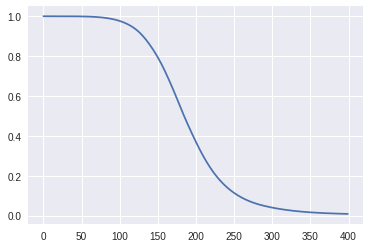

In [7]:
# Plot the probability of the target class wrt epochs
plt.plot(np.arange(0,len(prev_probs)), prev_probs)
plt.show()

In [0]:
np.save('x', x)
np.save('x_adv', x_adv)